In [1]:
'''
Segment the OASIS brain data set with an Improved UNet.

@author Aghnia Prawira (45610240)
'''

import data_processing as dp
import improved_unet as iu
from importlib import reload
reload(dp)
reload(iu)

import os
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


Tensorflow version: 2.1.0
Tensorflow version: 2.1.0


In [2]:
dp.test()
iu.test()

Testing data processing.
Testing improved unet.


In [3]:
# Set path to dataset
dataset_path = "keras_png_slices_data/"

seg_test_path = dataset_path + "keras_png_slices_seg_test/"
seg_train_path = dataset_path + "keras_png_slices_seg_train/"
seg_val_path = dataset_path + "keras_png_slices_seg_validate/"
test_path = dataset_path + "keras_png_slices_test/"
train_path = dataset_path + "keras_png_slices_train/"
val_path = dataset_path + "keras_png_slices_validate/"

In [4]:
# Load images
reload(dp)
seg_test = dp.load_image(seg_test_path)
seg_train = dp.load_image(seg_train_path)
seg_val = dp.load_image(seg_val_path)
test = dp.load_image(test_path)
train = dp.load_image(train_path)
val = dp.load_image(val_path)

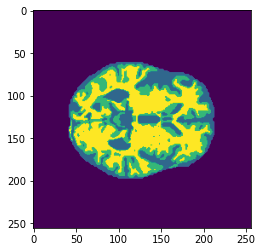

In [5]:
plt.imshow(seg_train[0])

In [6]:
# One hot encode labels
seg_test = dp.one_hot_encode(seg_test)

In [7]:
seg_train = dp.one_hot_encode(seg_train)

In [8]:
seg_val = dp.one_hot_encode(seg_val)

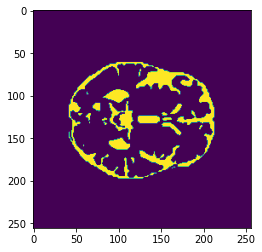

In [9]:
plt.imshow(seg_train[0][:,:,2])

In [10]:
print(np.array(train).shape)
print(np.array(seg_train).shape)

(100, 256, 256, 1)
(100, 256, 256, 4)


In [17]:
reload(iu)
# Generate improved unet model
model = iu.unet()

Tensorflow version: 2.1.0
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 256, 256, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_26 (LeakyReLU)      (None, 256, 256, 16) 0           conv2d_27[0][0]                  
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 256, 256, 16) 2320        leaky_re_lu_26[0][0]             
__________________________________________________________________

In [22]:
#Compile the model
# model.compile(optimizer='adam', 
#               loss='binary_crossentropy', metrics=[iu.dice_coefficient_avg])
model.compile(optimizer='adam', 
              loss=iu.dice_loss, metrics=[iu.dice_coefficient_avg])

In [23]:
# Train the model
history = model.fit(np.array(train), np.array(seg_train), 
                    batch_size=32, epochs=150, 
                    validation_data=(np.array(val), np.array(seg_val)))

Train on 100 samples, validate on 100 samples
Epoch 1/150
100/100 [==============================] - 2s 21ms/step - loss: 0.0937 - dice_coefficient_avg: 0.9056 - val_loss: 0.1286 - val_dice_coefficient_avg: 0.8736
Epoch 2/150
100/100 [==============================] - 1s 13ms/step - loss: 0.0811 - dice_coefficient_avg: 0.9191 - val_loss: 0.1356 - val_dice_coefficient_avg: 0.8661
Epoch 3/150
100/100 [==============================] - 1s 13ms/step - loss: 0.0751 - dice_coefficient_avg: 0.9248 - val_loss: 0.1327 - val_dice_coefficient_avg: 0.8695
Epoch 4/150
100/100 [==============================] - 1s 13ms/step - loss: 0.0716 - dice_coefficient_avg: 0.9310 - val_loss: 0.1354 - val_dice_coefficient_avg: 0.8660
Epoch 5/150
100/100 [==============================] - 1s 13ms/step - loss: 0.0703 - dice_coefficient_avg: 0.9316 - val_loss: 0.1337 - val_dice_coefficient_avg: 0.8686
Epoch 6/150
100/100 [==============================] - 1s 13ms/step - loss: 0.0675 - dice_coefficient_avg: 0.9330 

100/100 [==============================] - 1s 13ms/step - loss: 0.0537 - dice_coefficient_avg: 0.9470 - val_loss: 0.1359 - val_dice_coefficient_avg: 0.8660
Epoch 50/150
100/100 [==============================] - 1s 13ms/step - loss: 0.0532 - dice_coefficient_avg: 0.9463 - val_loss: 0.1350 - val_dice_coefficient_avg: 0.8670
Epoch 51/150
100/100 [==============================] - 1s 13ms/step - loss: 0.0532 - dice_coefficient_avg: 0.9462 - val_loss: 0.1350 - val_dice_coefficient_avg: 0.8673
Epoch 52/150
100/100 [==============================] - 1s 13ms/step - loss: 0.0528 - dice_coefficient_avg: 0.9463 - val_loss: 0.1356 - val_dice_coefficient_avg: 0.8665
Epoch 53/150
100/100 [==============================] - 1s 13ms/step - loss: 0.0525 - dice_coefficient_avg: 0.9479 - val_loss: 0.1358 - val_dice_coefficient_avg: 0.8661
Epoch 54/150
100/100 [==============================] - 1s 13ms/step - loss: 0.0522 - dice_coefficient_avg: 0.9481 - val_loss: 0.1349 - val_dice_coefficient_avg: 0.8672

100/100 [==============================] - 1s 13ms/step - loss: 0.0468 - dice_coefficient_avg: 0.9538 - val_loss: 0.1357 - val_dice_coefficient_avg: 0.8666
Epoch 98/150
100/100 [==============================] - 1s 13ms/step - loss: 0.0465 - dice_coefficient_avg: 0.9543 - val_loss: 0.1352 - val_dice_coefficient_avg: 0.8672
Epoch 99/150
100/100 [==============================] - 1s 13ms/step - loss: 0.0466 - dice_coefficient_avg: 0.9545 - val_loss: 0.1364 - val_dice_coefficient_avg: 0.8655
Epoch 100/150
100/100 [==============================] - 1s 13ms/step - loss: 0.0466 - dice_coefficient_avg: 0.9533 - val_loss: 0.1358 - val_dice_coefficient_avg: 0.8667
Epoch 101/150
100/100 [==============================] - 1s 13ms/step - loss: 0.0472 - dice_coefficient_avg: 0.9535 - val_loss: 0.1366 - val_dice_coefficient_avg: 0.8656
Epoch 102/150
100/100 [==============================] - 1s 13ms/step - loss: 0.0468 - dice_coefficient_avg: 0.9525 - val_loss: 0.1359 - val_dice_coefficient_avg: 0.8

100/100 [==============================] - 1s 13ms/step - loss: 0.0417 - dice_coefficient_avg: 0.9586 - val_loss: 0.1358 - val_dice_coefficient_avg: 0.8660
Epoch 146/150
100/100 [==============================] - 1s 13ms/step - loss: 0.0416 - dice_coefficient_avg: 0.9589 - val_loss: 0.1355 - val_dice_coefficient_avg: 0.8663
Epoch 147/150
100/100 [==============================] - 1s 13ms/step - loss: 0.0422 - dice_coefficient_avg: 0.9573 - val_loss: 0.1359 - val_dice_coefficient_avg: 0.8661
Epoch 148/150
100/100 [==============================] - 1s 13ms/step - loss: 0.0422 - dice_coefficient_avg: 0.9582 - val_loss: 0.1358 - val_dice_coefficient_avg: 0.8662
Epoch 149/150
100/100 [==============================] - 1s 13ms/step - loss: 0.0419 - dice_coefficient_avg: 0.9574 - val_loss: 0.1350 - val_dice_coefficient_avg: 0.8668
Epoch 150/150
100/100 [==============================] - 1s 13ms/step - loss: 0.0420 - dice_coefficient_avg: 0.9581 - val_loss: 0.1361 - val_dice_coefficient_avg: 0

In [24]:
test_loss, test_acc = model.evaluate(np.array(test),  np.array(seg_test), verbose=2)
print(test_acc)

0.8675194978713989


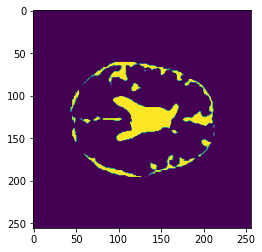

In [32]:
prediction = model.predict(np.array(test))
plt.imshow(prediction[3][:,:,2])

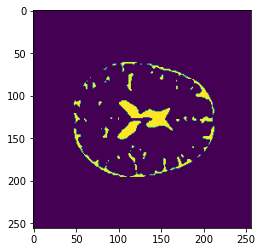

In [33]:
plt.imshow(seg_test[3][:,:,2])